# Figure 4

In [1]:
import os.path as op
import pandas as pd
import numpy as np
from sklearn import preprocessing, linear_model
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import plotutils

In [2]:
df_dir = op.join('..', 'data', 'dataframes')

In [3]:
subjects, rois, tasks = plotutils.default_data()

In [4]:
plotutils.set_plot_style()

### Load dataframes

In [5]:
ang_data = pd.read_csv(op.join(df_dir, 'group_ang_data.csv'))
params = pd.read_csv(op.join(df_dir, 'group_ang_fits.csv'))

ang_boots = pd.read_csv(op.join(df_dir, 'group_ang_data_boots.csv'))
params_boot = pd.read_csv(op.join(df_dir, 'group_ang_fits_boots.csv'))

### Figure 4b

In [6]:
pal = ['#d95f02', '#e6a778']
pal_dict = dict(zip(tasks, pal))
z = dict(zip(tasks, [0, 10]))

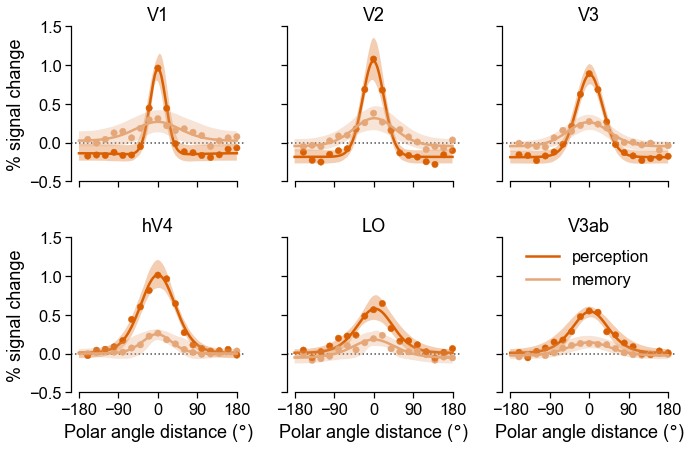

In [7]:
## Plot bold response by angular distance bin 
g = sns.relplot(x='ang_dist_bin', y='beta_adj', col='roi', col_order=rois, 
                hue='task', hue_order=['perception', 'memory'], kind='scatter',
                s=40, edgecolor=None, legend=False, col_wrap=3, 
                palette=pal, height=3.3, aspect=1, data=ang_data)

## Plot the fit von mises distributions and error bars for each panel
theta = np.linspace(-np.pi, np.pi, 361) 

for (r, t) in itertools.product(g.col_names, tasks):
    
    # von mises fit to data
    ax_i = rois.index(r)
    p = params.query("roi==@r & task==@t")[['loc', 'kappa1', 'scale1', 'kappa2', 'scale2']].iloc[0]
    yhat = plotutils.diff_vonmises(theta, *p)
    g.axes.flatten()[ax_i].plot(np.rad2deg(theta), yhat, linewidth=2.5,
                                zorder=z[t], c=pal_dict[t], label=t) 
    
    # err bands over von mises
    bfits = []
    for i, pg in params_boot.query("roi==@r & task==@t").groupby('n_boot'):
        p_i = pg[['loc', 'kappa1', 'scale1', 'kappa2', 'scale2']].iloc[0]
        yhat = plotutils.diff_vonmises(theta, *p_i)
        bfits.append(yhat)
    err_bands = np.nanpercentile(np.vstack(bfits), [2.5, 97.5], axis=0)
    g.axes.flatten()[ax_i].fill_between(np.rad2deg(theta), *err_bands, facecolor=pal_dict[t], 
                                        alpha=.3, zorder=z[t])

g.map(plt.axhline, y=0, c=".3", linewidth=1.5, ls=":", zorder=-10)
g.set(xticks=np.arange(-180, 225, 90), ylim=[-.5, 1.5], yticks=[-.5, 0, .5, 1, 1.5])
g.set_xlabels('Polar angle distance ($\\degree$)')
g.set_ylabels('% signal change')
g.set_titles(col_template="{col_name}")

plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[:2], labels[:2], loc='center left', frameon=False, bbox_to_anchor=(.05, 0.8))

sns.despine(trim=True)
plt.gcf().tight_layout(h_pad=1.5, w_pad=1.5)

### Figure 4c

In [8]:
# Melt params and boot data 
params_plot = params.melt(id_vars=['hemi', 'roi', 'task', 'func'], 
                          value_vars= ['loc_deg', 'amp', 'fwhm_deg'], 
                          var_name='param')

pboots_plot = params_boot.melt(id_vars=['hemi', 'roi', 'task', 'func', 'n_boot'], 
                               value_vars= ['loc_deg', 'amp', 'fwhm_deg'],
                               var_name='param')

# Generate CIs from bootstrapped params
params_conf = plotutils.params_ci(params_boot)

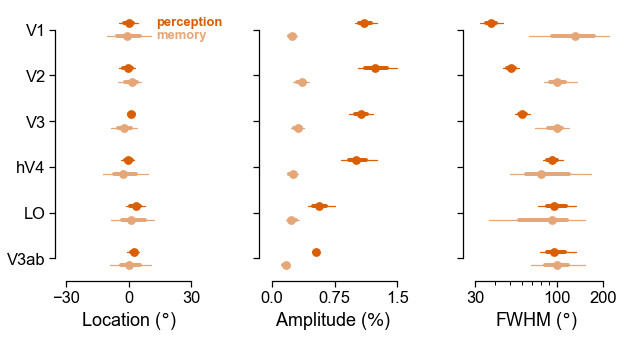

In [9]:
pars = ['loc_deg', 'amp', 'fwhm_deg']
dodge_dict = dict(zip(tasks, [-.15, .15]))
lw = dict(zip([68, 95], [4, 1.25]))

# Plot params
g = sns.catplot(y='roi', x='value', order=rois, col='param', col_order=pars,
                hue='task', hue_order=['perception', 'memory'], palette=pal, 
                kind='point',  dodge=.3, join=False, orient='h', 
                height=5, aspect=.6,  sharey=True, sharex=False, legend=False,
                data=params_plot)

# Plot both 68% and 95% confidence intervals
fwhm_grouped = params_conf.groupby(['param', 'roi', 'task', 'conf_level'])
yvals = dict(zip(rois, np.arange(len(rois))))

for (p,r,m,c), fg in fwhm_grouped:
    ax_i = pars.index(p)
    g.axes[0][ax_i].plot(fg['ci'].values[0], [yvals[r]+dodge_dict[m], yvals[r]+dodge_dict[m]], 
                         linewidth=lw[c], c=pal_dict[m], alpha=1, 
                         solid_capstyle='round')


g.axes[0][2].set_xscale('log')
plt.setp(g.axes[0][2].get_xminorticklabels(), visible=False)

g.axes[0][0].set(xlim=[-35, 35], xticks=[-30, 0, 30])
g.axes[0][1].set(xlim=[-.15, 1.6], xticks=[0, .75, 1.5], xticklabels=["0.0", "0.75", "1.5"])
g.axes[0][2].set(xlim=[25, 220], xticks=[30, 100, 200], xticklabels=["30", "100", "200"])
g.set(ylim=[5.5, -.5])
g.set_ylabels('')
g.set_titles('')
g.axes[0][0].text(13, -.1, 'perception', fontsize=13, fontweight='demibold', c=pal[0])
g.axes[0][0].text(13, .2, 'memory', fontsize=13, fontweight='demibold', c=pal[1])

sns.despine(trim=True)
plt.gcf().tight_layout(w_pad=2)

g.axes[0][0].set_xlabel('Location ($\\degree$)');
g.axes[0][1].set_xlabel('Amplitude ($\%$)');
g.axes[0][2].set_xlabel('FWHM ($\\degree$)');

### Params and CI numbers

In [10]:
params_conf['ci_range'] = params_conf['ci'].apply(lambda x: x[1] - x[0])

***Location confidence intervals***

All confidence intervals

In [11]:
params_conf.query("param=='loc_deg'")

,hemi,roi,task,param,conf_level,ci,ci_range
2,b,LO,memory,loc_deg,68,"[-3.23969702193135, 7.887233947012326]",11.126931
5,b,LO,perception,loc_deg,68,"[0.8770745553184836, 5.626800037131041]",4.749725
8,b,V1,memory,loc_deg,68,"[-5.645314903240259, 5.407475101993741]",11.052790
11,b,V1,perception,loc_deg,68,"[-2.067998727177045, 2.2355925496548026]",4.303591
14,b,V2,memory,loc_deg,68,"[-1.461560769733352, 3.909816985472375]",5.371378
17,b,V2,perception,loc_deg,68,"[-2.4409141705639796, 1.4136461900100519]",3.854560
20,b,V3,memory,loc_deg,68,"[-5.1675335744577575, 1.1603971434984226]",6.327931
23,b,V3,perception,loc_deg,68,"[0.21218466254297427, 2.393875812505912]",2.181691
26,b,V3ab,memory,loc_deg,68,"[-3.6352770400516716, 5.680622440492784]",9.315899
29,b,V3ab,perception,loc_deg,68,"[1.0399447114074243, 3.5913083042625433]",2.551364


Mean size of confidence intervals for each task

In [12]:
params_conf.query("param=='loc_deg'").groupby(['task', 'conf_level']).mean()

ci_range
task       conf_level           
memory     68           8.981536
           95          17.603485
perception 68           3.465142
           95           6.986945

Min and max size of confidence intervals for each task

In [13]:
params_conf.query("param=='loc_deg'").groupby(['task', 'conf_level'])['ci_range'].agg([np.min, np.max])

amin       amax
task       conf_level                      
memory     68           5.371378  11.126931
           95          11.032228  21.272023
perception 68           2.181691   4.749725
           95           3.950523   9.475685

***Amplitude values and confidence intervals***

Mean amplitude for each task

In [14]:
params_plot.query("param=='amp'").groupby('task').mean()

,value
task,
memory,0.259839
perception,0.919434


Amplitude difference between perception and memory for each ROI

In [15]:
amp_params_wide = params_plot.query("param=='amp'").pivot_table(index='roi', columns='task', values='value')
(amp_params_wide['perception'] - amp_params_wide['memory']).sort_values()

roi
LO      0.336427
V3ab    0.366342
hV4     0.756610
V3      0.757960
V1      0.860960
V2      0.879271
dtype: float64

All confidence intervals

In [16]:
params_conf.query("param=='amp'")

,hemi,roi,task,param,conf_level,ci,ci_range
0,b,LO,memory,amp,68,"[0.20535759705760673, 0.28550812673658044]",0.080151
3,b,LO,perception,amp,68,"[0.49238287193447494, 0.6482766818999693]",0.155894
6,b,V1,memory,amp,68,"[0.20391134436860087, 0.2724159231884233]",0.068505
9,b,V1,perception,amp,68,"[1.0462178336194263, 1.1892382176044765]",0.143020
12,b,V2,memory,amp,68,"[0.3063858118888681, 0.3971875112697455]",0.090802
15,b,V2,perception,amp,68,"[1.1125712932562954, 1.371527959947466]",0.258957
18,b,V3,memory,amp,68,"[0.27107959431941064, 0.34970265164493797]",0.078623
21,b,V3,perception,amp,68,"[0.9951440277014991, 1.1423931201889492]",0.147249
24,b,V3ab,memory,amp,68,"[0.13856774179319892, 0.1909239193427541]",0.052356
27,b,V3ab,perception,amp,68,"[0.5036132927312555, 0.5573046816491198]",0.053691


***FWHM values and confidence intervals***

Mean FWHM for each task

In [17]:
params_plot.query("param=='fwhm_deg'").groupby(["task"]).mean()

,value
task,
memory,101.000000
perception,72.833333


All FWHM values

In [18]:
params_plot.query("param=='fwhm_deg'")

,hemi,roi,task,func,param,value
24,b,LO,memory,diff_vonmises,fwhm_deg,94.0
25,b,LO,perception,diff_vonmises,fwhm_deg,97.0
26,b,V1,memory,diff_vonmises,fwhm_deg,131.0
27,b,V1,perception,diff_vonmises,fwhm_deg,38.0
28,b,V2,memory,diff_vonmises,fwhm_deg,101.0
29,b,V2,perception,diff_vonmises,fwhm_deg,51.0
30,b,V3,memory,diff_vonmises,fwhm_deg,100.0
31,b,V3,perception,diff_vonmises,fwhm_deg,60.0
32,b,V3ab,memory,diff_vonmises,fwhm_deg,101.0
33,b,V3ab,perception,diff_vonmises,fwhm_deg,97.0


Ratio of memory to perception FWHM for each roi

In [19]:
fwhm_params_wide = params_plot.query("param=='fwhm_deg'").pivot_table(index='roi', columns='task', values='value')
(fwhm_params_wide['memory'] / fwhm_params_wide['perception']).sort_values()

roi
hV4     0.840426
LO      0.969072
V3ab    1.041237
V3      1.666667
V2      1.980392
V1      3.447368
dtype: float64

All confidence intervals

In [20]:
params_conf.query("param=='fwhm_deg'")

,hemi,roi,task,param,conf_level,ci,ci_range
1,b,LO,memory,fwhm_deg,68,"[57.00000000000001, 116.0]",59.000
4,b,LO,perception,fwhm_deg,68,"[87.00000000000001, 115.0]",28.000
7,b,V1,memory,fwhm_deg,68,"[92.84, 173.15999999999997]",80.320
10,b,V1,perception,fwhm_deg,68,"[35.0, 41.0]",6.000
13,b,V2,memory,fwhm_deg,68,"[91.0, 113.0]",22.000
16,b,V2,perception,fwhm_deg,68,"[48.00000000000001, 54.0]",6.000
19,b,V3,memory,fwhm_deg,68,"[88.0, 109.0]",21.000
22,b,V3,perception,fwhm_deg,68,"[57.00000000000001, 64.0]",7.000
25,b,V3ab,memory,fwhm_deg,68,"[84.0, 119.0]",35.000
28,b,V3ab,perception,fwhm_deg,68,"[87.00000000000001, 113.0]",26.000


### Statistical Models

Function definitions for testing effects of task and roi

In [21]:
def interaction_model(data, roi_order):
    """Fit linear model testing effect of roi, perception/memory and interaction on params"""
    
    # Get y values
    y = data['value'].values.reshape(-1, 1) 
    
    # Create design matrix (roi, task, roi*task)
    x1 = data['roi'].values.reshape(-1, 1) #roi, coded ordinally by roi_order
    x1 = preprocessing.OrdinalEncoder(categories=[np.array(roi_order)]).fit_transform(x1)

    x2 = data['task'].values #task (perception versus memory)
    x2 = preprocessing.LabelEncoder().fit_transform(x2).reshape(-1, 1)
    
    x3 = x1 * x2 #interaction between roi and task
    x = np.hstack([x1, x2, x3])
    
    # Run model 
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    coeff = regr.coef_.flatten()
    
    return coeff

In [22]:
def roi_model(data, roi_order):
    """Fit linear model testing effect of roi on params"""
    
    # Get y values
    y = data['value'].values.reshape(-1, 1) 
    
    # Make design matrix (roi)
    x = data['roi'].values.reshape(-1, 1) #roi
    x = preprocessing.OrdinalEncoder(categories=[np.array(roi_order)]).fit_transform(x)
    
    # Run model
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    coeff = regr.coef_.flatten()
    
    return coeff

In [23]:
def ci_model(data, roi_order, model_func):
    
    coeffs = []
    for i, g in data.groupby("n_boot"):
        g = g.replace({np.inf:np.nan}).dropna()
        bcoeff = model_func(g, roi_order)
        coeffs.append(bcoeff)
        
    ci_coeffs = np.nanpercentile(coeffs, [2.5, 97.5], axis=0)
    
    return ci_coeffs

***Location ~ roi * task***

In [24]:
loc_params = params_plot.query("param=='loc_deg'")
loc_boots = pboots_plot.query("param=='loc_deg'")

In [25]:
int_coeff = interaction_model(loc_params, rois)
int_ci = ci_model(loc_boots, rois, interaction_model)

In [26]:
for i, factor in enumerate(['roi', 'task', 'interaction']):
    print("%s coeff = %.3f, 95CI: %s" %(factor, int_coeff[i], int_ci[:, i]))

roi coeff = 0.075, 95CI: [-2.22143806  2.65493719]
task coeff = 0.136, 95CI: [-6.71722792  6.14201848]
interaction coeff = 0.535, 95CI: [-1.94431914  2.6021658 ]


***Amplitude ~ roi * task***

In [27]:
amp_params = params_plot.query("param=='amp'")
amp_boots = pboots_plot.query("param=='amp'")

In [28]:
int_coeff = interaction_model(amp_params, rois)
int_ci = ci_model(amp_boots, rois, interaction_model)

In [29]:
for i, factor in enumerate(['roi', 'task', 'interaction']):
     print("%s coeff = %.3f, 95CI: %s" %(factor, int_coeff[i], int_ci[:, i]))

roi coeff = -0.023, 95CI: [-0.0345013  -0.00827619]
task coeff = 0.953, 95CI: [0.80138253 1.13384199]
interaction coeff = -0.117, 95CI: [-0.15736365 -0.08243531]


***FWHM ~ roi * task***

In [30]:
fwhm_params = params_plot.query("param=='fwhm_deg'")
fwhm_boots = pboots_plot.query("param=='fwhm_deg'")

In [31]:
int_coeff = interaction_model(fwhm_params, rois)
int_ci = ci_model(fwhm_boots, rois, interaction_model)

In [32]:
for i, factor in enumerate(['roi', 'task', 'interaction']):
     print("%s coeff = %.3f, 95CI: %s" %(factor, int_coeff[i], int_ci[:, i]))

roi coeff = -5.486, 95CI: [-18.71857143   8.40642857]
task coeff = -75.238, 95CI: [-138.53452381  -33.07738095]
interaction coeff = 18.829, 95CI: [ 5.77928571 35.50357143]


***Perception FWHM ~ roi***

In [33]:
per_fwhm = fwhm_params.query("task=='perception'")
per_fwhm_boots = fwhm_boots.query("task=='perception'")
per_coeff = roi_model(per_fwhm, rois)
per_ci = ci_model(per_fwhm_boots, rois, roi_model)
print("Roi coeff = %.3f, 95CI: %s" %(per_coeff[0], per_ci[:, 0]))

Roi coeff = 13.343, 95CI: [10.34142857 20.64357143]


***Memory FWHM ~ roi***

In [34]:
mem_fwhm = fwhm_params.query("task=='memory'")
mem_fwhm_boots = fwhm_boots.query("task=='memory'")
mem_coeff = roi_model(mem_fwhm, rois)
mem_ci = ci_model(mem_fwhm_boots, rois, roi_model)
print("Roi coeff = %.3f, 95CI: %s" %(mem_coeff[0], mem_ci[:, 0]))

Roi coeff = -5.486, 95CI: [-18.71857143   8.40642857]
